# Importing libraries

In [77]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [78]:
# Importing data and creating a master data
train_data = pd.read_csv(r"C:\Users\fafar\OneDrive\Desktop\Desktop\PHD\kaggle\House_pricing\train.csv")
test_data = pd.read_csv(r"C:\Users\fafar\OneDrive\Desktop\Desktop\PHD\kaggle\House_pricing\test.csv")

In [79]:
# Parameters
Column_Number = 4

# Removing Label from data

In [80]:
train_data.drop("Id", axis=1, inplace=True)
test_data.drop("Id", axis=1, inplace=True)

Label = "SalePrice"
Types = train_data.dtypes
fig_list = []


# Drawing correlation between label and other columns


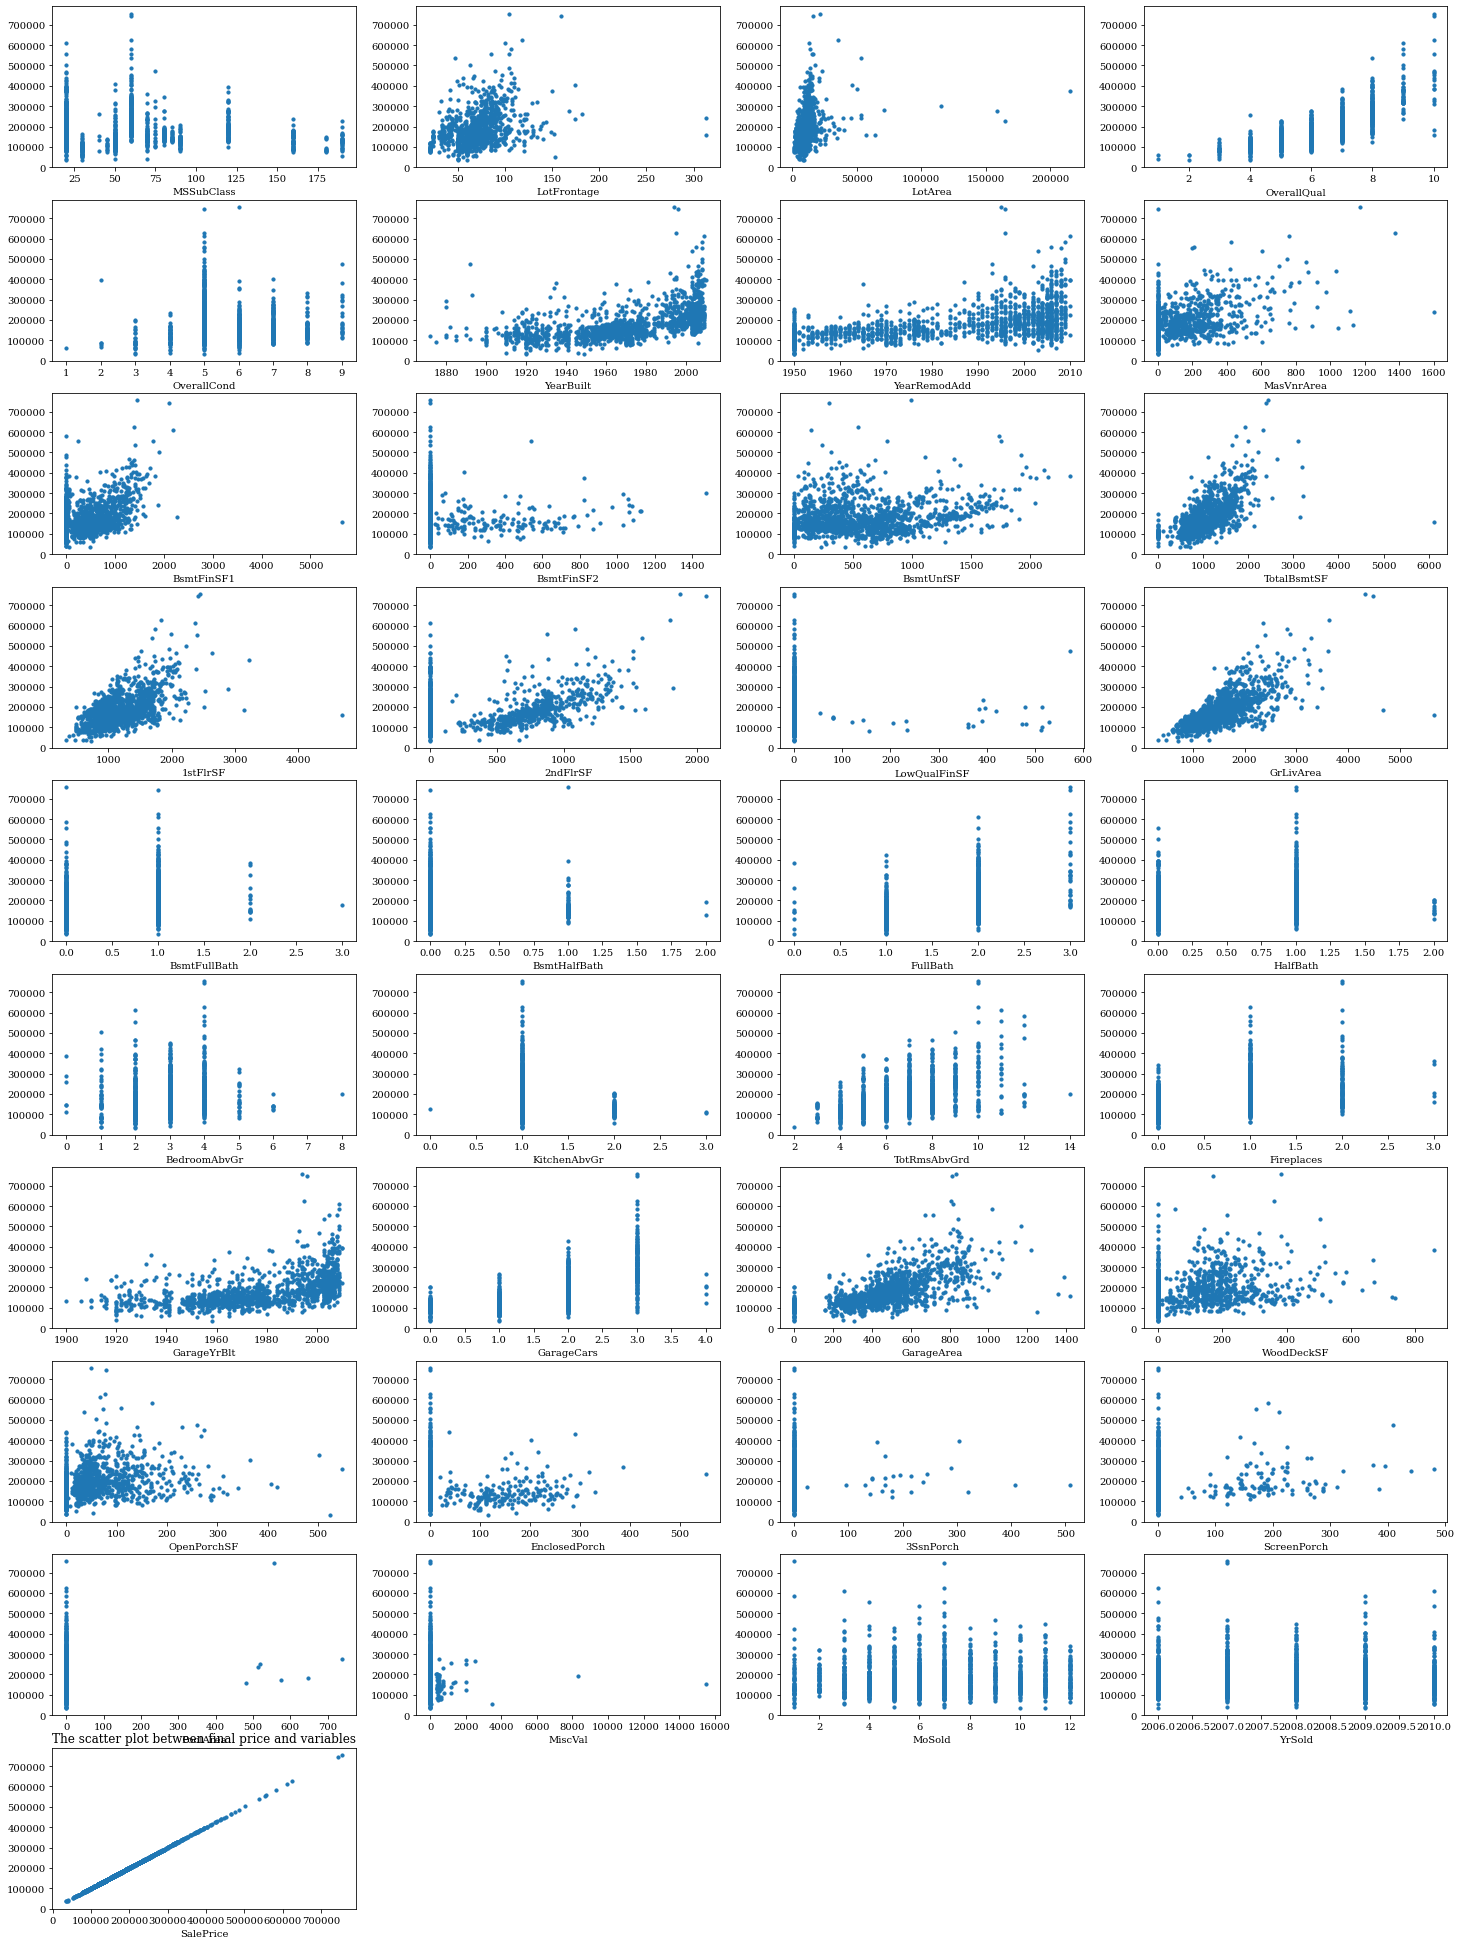

In [81]:
# Creating a list of numeric columns

for i in range(0, train_data.shape[1]):
    temp_col_name = train_data.columns[i]
    if (Types[temp_col_name].type != np.object_):
        fig_list.append(i)

plt.rcParams["figure.figsize"] = (25, 35)
for k in range(0, len(fig_list)):
    plt.rcParams['font.family'] = 'DeJavu Serif'
    plt.rcParams['font.serif'] = ['Times New Roman']
    plt.subplot((len(fig_list) / Column_Number) + 1, Column_Number, k+1)
    plt.scatter(train_data[train_data.columns[fig_list[k]]], train_data[Label],s=10)
    plt.xlabel(train_data.columns[fig_list[k]])


plt.title("The scatter plot between final price and variables")
# plt.savefig("Scatter.png")
plt.show()


# Finding distribution of columns for transformation

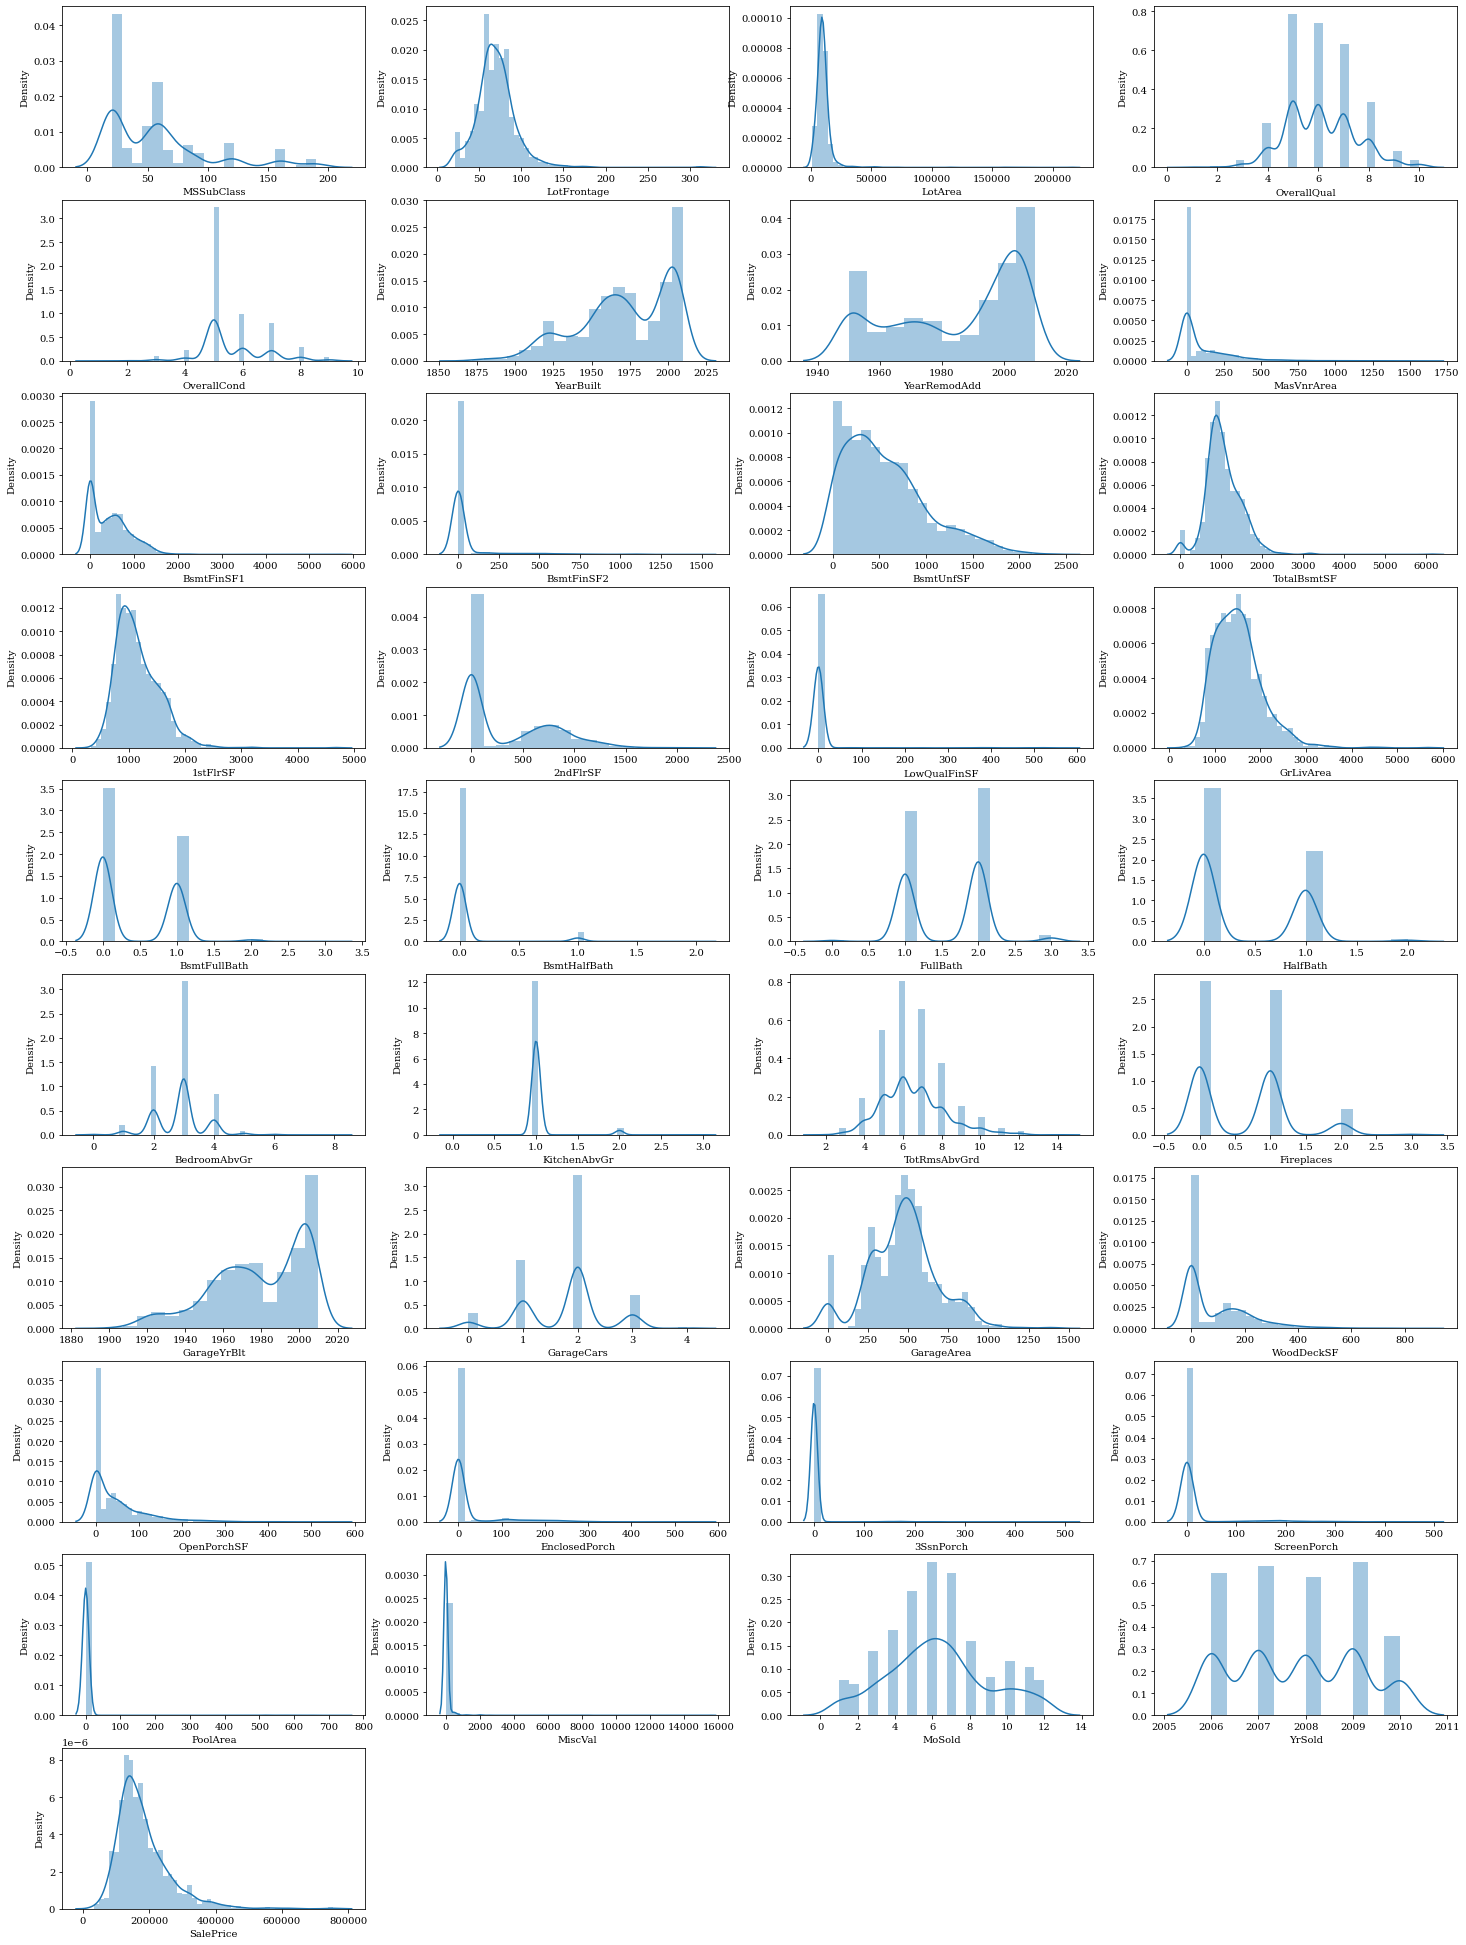

In [82]:
plt.rcParams["figure.figsize"] = (25, 35)

for k in range(0, len(fig_list)):
    plt.rcParams['font.family'] = 'DeJavu Serif'
    plt.rcParams['font.serif'] = ['Times New Roman']
    plt.subplot((len(fig_list) / Column_Number) + 1, Column_Number, k+1)
    sns.distplot(train_data[train_data.columns[fig_list[k]]])
    plt.xlabel(train_data.columns[fig_list[k]])

# plt.savefig("Density.png")

plt.show()


# Investigating the effect of logaritmic transformation on label

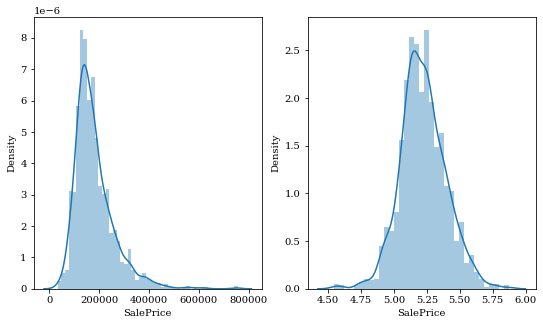

In [83]:
# Using logaritmic transformation for final price in order to convert its distribution to normal one
plt.rcParams["figure.figsize"] = (9, 5)
plt.subplot(1, 2, 1)
sns.distplot((train_data[Label]))
plt.subplot(1, 2, 2)
sns.distplot(np.log10(train_data[Label] + 1))
plt.show()


# Depicting count of null values

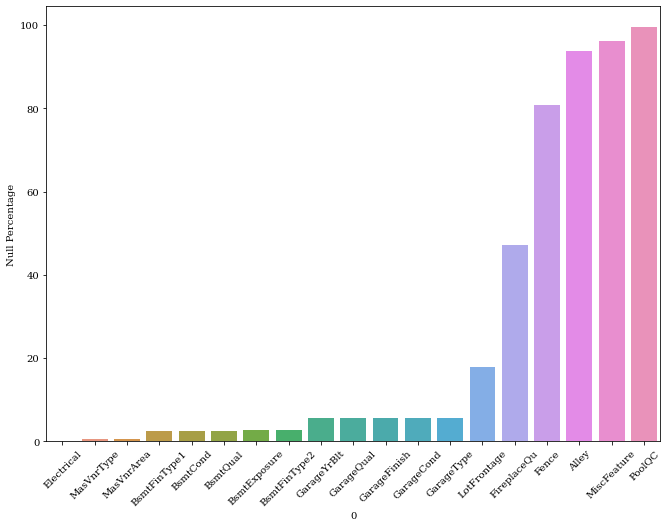

In [84]:
train_data[Label] = np.log10(train_data[Label])

Null_counts = np.zeros((np.shape(train_data)[1], 2))
Null_counts = pd.DataFrame(Null_counts)

for i in range(0, np.shape(train_data)[1]):
    Null_counts[0].iloc[i] = train_data.columns[i]
    Null_counts[1].iloc[i] = pd.isna(train_data[train_data.columns[i]]).sum()

plt.rcParams["figure.figsize"] = (11, 8)
Null_counts = Null_counts.sort_values(1)
Null_counts = Null_counts[Null_counts[1] > 0]
Null_counts[1] = 100* (Null_counts[1] / np.shape(train_data)[0])
sns.barplot(Null_counts[0], Null_counts[1])
plt.xticks(rotation = 45)
plt.ylabel("Null Percentage")
# plt.savefig("Null_Percentage.png")
plt.show()


In [85]:
train_data['MSSubClass'] = train_data['MSSubClass'].apply(str)
train_data['YrSold'] = train_data['YrSold'].astype(str)
train_data['MoSold'] = train_data['MoSold'].astype(str)


# Defining Missing value and outlier handler function

In [86]:

def Misiing_Value_Handler(data, Type_Status):
    """
    :data: Target column
    :Type_Status: Type of column
    """

    if (Type_Status):
        Col = data.fillna(data.iloc[data.value_counts().argmax()])
    else:
        Col = data.fillna(data.mean())

    return Col

def Outlier_Handler(data, column_name):

    """
    :param data: Entire data set for using other features in cleaning outliers
    :param column_name: The desire column which should be cleaned
    :return: This function returns the cleand data with reduced rows
    """
    # This part checks the existence of outlier through the IQR method
    IQR_outliers = []
    sorted_data = sorted(data[column_name])
    q1 = np.percentile(sorted_data, 25)
    q3 = np.percentile(sorted_data, 75)
    IQR = q3 - q1
    lwr_bound = q1 - (1.5 * IQR)
    upr_bound = q3 + (1.5 * IQR)
    for i in data[column_name]:
        if ((i < lwr_bound) or (i > upr_bound)):
            IQR_outliers.append(i)

    # This part checks the existence of outlier through the Zscore method
    Zscore_outliers = []
    lcl = data[column_name].mean() - 2.64 * data[column_name].std()
    ucl = data[column_name].mean() + 2.64 * data[column_name].std()

    for i in data[column_name]:
        if ((i < lcl) or (i > ucl)):
            Zscore_outliers.append(i)

    non_outliers = []
    for i in range(0, len(data[column_name])):
        if not ((data[column_name].iloc[i] in IQR_outliers) and (data[column_name].iloc[i] in Zscore_outliers)):
            non_outliers.append(i)

    data = data.iloc[non_outliers]
    return data


# Adding new features 

It's a good aidea to add new columns

# Data cleansing

In [87]:
Types = train_data.dtypes
delete_columns = []
Encoders = {}

for i in range(0 , len(train_data.columns)):

    temp_col_name = train_data.columns[i]
    Nan_proportion = pd.isna(train_data[temp_col_name]).sum() / len(train_data[temp_col_name])

    if (Types[temp_col_name].type == np.object_):
        Type_Status = True
    else:
        Type_Status = False

    # Removing columns with high portion of null value and filling null value of others
    if temp_col_name != Label:
        if (Nan_proportion > 0.3):
            delete_columns.append(temp_col_name)
        else:
            train_data[temp_col_name] = Misiing_Value_Handler(train_data[temp_col_name] , Type_Status)

    if Type_Status:
        # Encoding categorical columns
        label_encoder = LabelEncoder()
        label_encoder.fit(train_data[temp_col_name])
        le_dict = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
        train_data[temp_col_name] = train_data[temp_col_name].apply(lambda x: le_dict.get(x, '<Unknown>'))
        Encoders[temp_col_name] = le_dict
    else:
        train_data = Outlier_Handler(train_data, temp_col_name)




train_data.drop(delete_columns, axis=1, inplace= True)
test_data.drop(delete_columns, axis=1, inplace= True)


In [88]:
# Applying some transformation for test data

Types_test = test_data.dtypes

for i in range(0 , ((len(test_data.columns)))):

    temp_col_name = test_data.columns[i]

    if (Types_test[temp_col_name].type == np.object_):
        Type_Status = True
    else:
        Type_Status = False

    test_data[temp_col_name] = Misiing_Value_Handler(test_data[temp_col_name], Type_Status)

    if (Types_test[temp_col_name].type == np.object_):
        test_data[temp_col_name] = test_data[temp_col_name].apply(lambda x: Encoders[temp_col_name].get(x, -1))


# Data transformation

In [89]:
skewness = np.zeros((train_data.shape[1],3))
skewness = pd.DataFrame(skewness)

# Applying BoxCox transformation for those with high value of skewness

for i in range(0, train_data.shape[1]):
    temp_col_name = train_data.columns[i]
    skewness[0].iloc[i] = temp_col_name

    if temp_col_name != Label:
        skewness[1].iloc[i] = train_data[temp_col_name].skew()
    else:
        skewness[1].iloc[i] = 0

    if (skewness[1].iloc[i] >= 0.5 and skewness[1].iloc[i] <= 10 ):

        skewness[2].iloc[i] = boxcox_normmax(train_data[temp_col_name] + 1)
        train_data[temp_col_name] = boxcox1p(train_data[temp_col_name], boxcox_normmax(train_data[temp_col_name] + 1))


for i in range(0, test_data.shape[1]):
    temp_col_name = test_data.columns[i]
    k = np.where(skewness[0] == temp_col_name)[0][0]
    if skewness[2].iloc[k] != 0:
        test_data[temp_col_name] = boxcox1p(test_data[temp_col_name], skewness[2].iloc[k])



In [90]:
# Applying some scaler on data

for i in range(0, train_data.shape[1]):
    temp_col_name = train_data.columns[i]
    train_data[temp_col_name] = np.float32(train_data[temp_col_name])

for i in range(0, test_data.shape[1]):
    temp_col_name = test_data.columns[i]
    test_data[temp_col_name] = np.float32(test_data[temp_col_name])

train_data.round(decimals=5)
test_data.round(decimals=5)

train_data.drop("Heating", inplace= True, axis= 1)
test_data.drop("Heating", inplace= True, axis= 1)
train_data.reset_index(inplace=True, drop=True)

scaled_data = train_data.drop([Label], axis=1)
column_name = scaled_data.columns
sc = StandardScaler()
Scaler = sc.fit(scaled_data)
scaled_data = sc.transform(scaled_data)
scaled_data = pd.DataFrame(scaled_data)

test_data = Scaler.transform(test_data)
test_data = pd.DataFrame(test_data)


In [91]:
# train_data = Scaler.transform(test_data)
# train_data = pd.DataFrame(scaled_data)


# Building model

In [92]:
model = RandomForestRegressor(n_estimators=100)
model.fit(scaled_data, train_data[Label])
predictions = model.predict(test_data)
predictions = np.power(10,predictions)-1
predictions = pd.DataFrame(predictions)


In [93]:
predictions

,0
0,123099.168108
1,147982.295037
2,183194.535850
3,183128.406584
4,199701.170818
...,...
1454,85350.205521
1455,85647.397215
1456,142327.981833
1457,113964.147159
